In [2]:
%%capture
import tensorflow as tf
import tensorflow_datasets as tfds
import numpy as np
import importlib as imp

from collections import namedtuple
from random import sample, shuffle
from functools import reduce
from itertools import accumulate
from math import floor, ceil, sqrt, log, pi
from tensorflow.keras import layers, utils, losses, models as mds, optimizers
from matplotlib import pyplot as plt

if imp.find_loader('aggdraw'): import aggdraw
if imp.find_loader('tensorflow_addons'): from tensorflow_addons import layers as tfa_layers

2022-03-16 11:00:48.529799: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-03-16 11:00:48.530967: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


## Summary

| Version | Depth | Skips | Others | Accuracy | Validation Accuracy |
| :-- | :-: | :-- | :-- | :-: | :-: |
| 3 | 20 | [2, 3, 5, 8] || 0.134314  |  0.103922 |
| 5 | 30 | [2, 3, 5, 8, 13, 21] | heat=1, chill=3, skip_start_depth=10 | 0.240196 | 0.137255 |
| 6 | 60 | [2, 3, 5, 8, 13, 21] | heat=1, chill=2, reheat=7, skip_start_depth=10 | 0.036275 | 0.037255 |
| 7 | 30 | [2, 3, 5, 8, 13, 21] || 0.134314 | 0.094118 |
| 8 | 30 | [2, 3, 5, 8, 13, 21] || 0.041176 | 0.035294 |
| 10 | 20 | [2, 3, 5, 8, 13] || 0.182353 | 0.083333 |
| 11 | 30 | [2, 3, 5, 8, 13, 21] | Conv Merge | 0.079412 | 0.055882 |
| 12 | 30 | [2, 3, 5, 8, 13, 21] | Dense Merge | 0.185294 | 0.089216 |
| 13 | 30 | [2, 3, 5, 8, 13] || 0.131373 | 0.098039 |

* Versions correspond to the kaggle [runs](https://www.kaggle.com/naresh/auto-model)

## Common Functions

In [ ]:
def plot_history(h):
    fig, axes = plt.subplots(1, 2, figsize=(10, 5), facecolor='w', edgecolor='k')

    axes[0].plot(h['loss'], label='Loss')
    axes[0].plot(h['val_loss'], label='Validation Loss')

    axes[0].set_xlabel('Epoch')
    axes[0].set_ylabel('Loss')
    axes[0].set_title('Losses')

    axes[1].plot(h['accuracy'], label='Accuracy')
    axes[1].plot(h['val_accuracy'], label='Validation Accuracy')

    axes[1].set_xlabel('Epoch')
    axes[1].set_ylabel('Accuracy')
    axes[1].set_title('Accuracies')

    fig.legend()

## Model 3 (depth=20, skips=[2, 3, 5, 8])

0.134314  |  0.103922


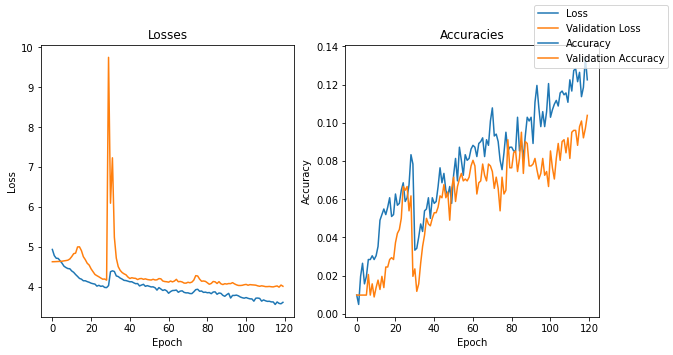

In [13]:
history = {'loss': [4.933203, 4.778612, 4.712742, 4.708459, 4.648549, 4.588217, 4.513692, 4.480162, 4.454505, 4.449397, 4.394504, 4.359779, 4.304623, 4.257103, 4.206994, 4.188591, 4.148404, 4.148549, 4.126994, 4.11091, 4.087538, 4.07413, 4.06407, 4.013563, 4.034152, 4.008312, 4.018239, 3.981055, 3.976682, 4.026988, 4.375055, 4.397504, 4.38144, 4.269544, 4.253957, 4.215819, 4.1906, 4.158627, 4.153378, 4.138384, 4.122829, 4.123641, 4.097038, 4.074889, 4.078626, 4.018622, 4.040771, 4.059194, 4.009147, 4.025974, 4.009773, 3.993738, 3.996207, 3.972915, 3.913933, 3.976903, 3.942168, 3.905067, 3.923758, 3.89599, 3.835392, 3.87707, 3.903397, 3.906101, 3.915708, 3.859696, 3.888864, 3.895969, 3.857346, 3.845021, 3.846014, 3.828249, 3.826698, 3.871985, 3.925412, 3.935275, 3.884717, 3.892021, 3.856905, 3.863206, 3.848062, 3.853007, 3.824827, 3.866418, 3.870789, 3.809691, 3.841761, 3.832773, 3.783296, 3.758727, 3.800392, 3.832429, 3.715098, 3.781051, 3.779994, 3.788924, 3.770988, 3.741774, 3.723493, 3.711463, 3.727117, 3.708482, 3.695006, 3.693289, 3.636789, 3.711948, 3.715095, 3.705999, 3.637983, 3.668371, 3.646361, 3.631687, 3.634435, 3.618837, 3.617585, 3.554697, 3.616818, 3.580964, 3.571679, 3.607831], 'accuracy': [0.009804, 0.004902, 0.019608, 0.026471, 0.015686, 0.019608, 0.028431, 0.028431, 0.030392, 0.028431, 0.030392, 0.035294, 0.04902, 0.051961, 0.054902, 0.051961, 0.055882, 0.060784, 0.05098, 0.051961, 0.062745, 0.056863, 0.057843, 0.064706, 0.068627, 0.058824, 0.060784, 0.067647, 0.083333, 0.078431, 0.033333, 0.034314, 0.040196, 0.047059, 0.043137, 0.053922, 0.054902, 0.060784, 0.05, 0.060784, 0.057843, 0.058824, 0.066667, 0.076471, 0.068627, 0.073529, 0.064706, 0.061765, 0.066667, 0.057843, 0.072549, 0.081373, 0.069608, 0.087255, 0.080392, 0.072549, 0.083333, 0.080392, 0.081373, 0.086275, 0.088235, 0.087255, 0.082353, 0.089216, 0.090196, 0.092157, 0.082353, 0.091176, 0.088235, 0.10098, 0.107843, 0.093137, 0.094118, 0.090196, 0.080392, 0.07549, 0.084314, 0.095098, 0.085294, 0.087255, 0.087255, 0.085294, 0.085294, 0.102941, 0.085294, 0.090196, 0.081373, 0.093137, 0.102941, 0.10098, 0.102941, 0.089216, 0.110784, 0.119608, 0.107843, 0.098039, 0.105882, 0.098039, 0.105882, 0.120588, 0.102941, 0.106863, 0.109804, 0.111765, 0.108824, 0.115686, 0.116667, 0.114706, 0.115686, 0.110784, 0.122549, 0.116667, 0.127451, 0.128431, 0.121569, 0.126471, 0.113725, 0.118627, 0.134314, 0.122549], 'val_loss': [4.62539, 4.62667, 4.629114, 4.631567, 4.634011, 4.638593, 4.647288, 4.654223, 4.66458, 4.693739, 4.75419, 4.82733, 4.840985, 4.996055, 4.998963, 4.904411, 4.752005, 4.677692, 4.587276, 4.541486, 4.446252, 4.37524, 4.306014, 4.275507, 4.24798, 4.216964, 4.18828, 4.192066, 4.163744, 9.749428, 6.092951, 7.23126, 5.240884, 4.715438, 4.50229, 4.409367, 4.355366, 4.322562, 4.297664, 4.242298, 4.204638, 4.224226, 4.21281, 4.208085, 4.178112, 4.200573, 4.204943, 4.184776, 4.19652, 4.180181, 4.172164, 4.16689, 4.18571, 4.168423, 4.172199, 4.203022, 4.197083, 4.142873, 4.12869, 4.12424, 4.113154, 4.141653, 4.1207, 4.142071, 4.184143, 4.12376, 4.131168, 4.118142, 4.090275, 4.089031, 4.110732, 4.098159, 4.114439, 4.164806, 4.276163, 4.268165, 4.189748, 4.136752, 4.142606, 4.132891, 4.098209, 4.060516, 4.081059, 4.130078, 4.121747, 4.080022, 4.126055, 4.071929, 4.053438, 4.074533, 4.065908, 4.078722, 4.076477, 4.101745, 4.070296, 4.046974, 4.031009, 4.029749, 4.034566, 4.048853, 4.05707, 4.036119, 4.051802, 4.045996, 4.042667, 4.037658, 4.020865, 4.010103, 4.022012, 4.013093, 4.001687, 4.001912, 4.006242, 3.998025, 3.994699, 4.008087, 4.018971, 3.987945, 4.041105, 4.010334], 'val_accuracy': [0.009804, 0.009804, 0.009804, 0.009804, 0.009804, 0.009804, 0.020588, 0.009804, 0.015686, 0.008824, 0.013725, 0.017647, 0.012745, 0.019608, 0.013725, 0.02451, 0.02451, 0.028431, 0.029412, 0.028431, 0.037255, 0.042157, 0.044118, 0.05, 0.066667, 0.064706, 0.066667, 0.053922, 0.061765, 0.019608, 0.023529, 0.011765, 0.015686, 0.026471, 0.035294, 0.041176, 0.05, 0.047059, 0.046078, 0.05, 0.052941, 0.052941, 0.055882, 0.061765, 0.060784, 0.067647, 0.060784, 0.063725, 0.04902, 0.065686, 0.071569, 0.058824, 0.066667, 0.070588, 0.073529, 0.069608, 0.070588, 0.069608, 0.071569, 0.077451, 0.080392, 0.077451, 0.062745, 0.068627, 0.069608, 0.078431, 0.072549, 0.069608, 0.078431, 0.077451, 0.07451, 0.065686, 0.071569, 0.065686, 0.053922, 0.071569, 0.062745, 0.064706, 0.091176, 0.076471, 0.076471, 0.084314, 0.085294, 0.07451, 0.081373, 0.095098, 0.073529, 0.090196, 0.089216, 0.077451, 0.077451, 0.078431, 0.081373, 0.07549, 0.070588, 0.073529, 0.081373, 0.072549, 0.07451, 0.066667, 0.085294, 0.076471, 0.070588, 0.081373, 0.089216, 0.080392, 0.090196, 0.091176, 0.084314, 0.092157, 0.081373, 0.095098, 0.096078, 0.096078, 0.088235, 0.098039, 0.10098, 0.092157, 0.097059, 0.103922]}

plot_history(history)
print(max(history['accuracy']), ' | ', max(history['val_accuracy']))

## Model 5 (depth=30, skips=[2, 3, 5, 8, 13, 21], heat=1, chill=3, skip_start_depth=10)

0.240196  |  0.137255


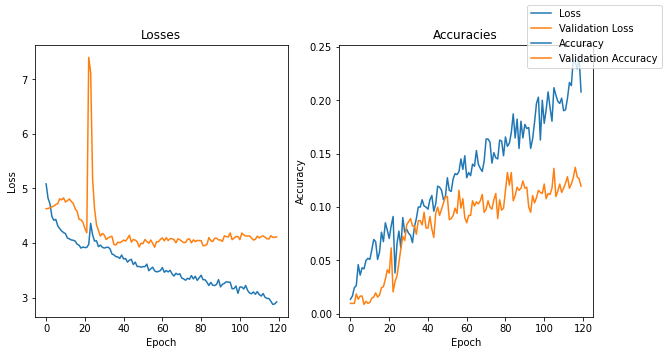

In [14]:
history = {'loss': [5.08202, 4.819621, 4.716983, 4.483245, 4.416396, 4.432909, 4.315057, 4.263754, 4.220068, 4.191669, 4.171094, 4.091025, 4.074702, 4.056173, 4.049688, 4.035142, 3.979259, 3.958887, 3.906689, 3.927642, 3.916417, 3.919084, 3.975762, 4.359375, 4.149557, 4.034146, 4.041173, 3.933278, 3.961383, 3.922744, 3.906954, 3.918675, 3.924459, 3.892485, 3.798182, 3.783285, 3.750587, 3.745043, 3.71676, 3.780182, 3.708059, 3.715294, 3.65002, 3.686789, 3.700323, 3.605301, 3.650727, 3.569188, 3.569695, 3.557832, 3.567948, 3.56724, 3.612507, 3.491871, 3.528569, 3.556596, 3.491038, 3.471278, 3.479214, 3.495702, 3.550088, 3.464159, 3.495129, 3.470653, 3.499215, 3.435348, 3.394361, 3.446206, 3.420403, 3.437433, 3.357577, 3.342773, 3.318233, 3.354416, 3.336018, 3.404278, 3.342278, 3.39087, 3.315174, 3.36144, 3.409714, 3.328965, 3.32656, 3.282478, 3.222616, 3.278791, 3.225756, 3.221463, 3.242636, 3.329258, 3.196331, 3.243092, 3.26086, 3.290672, 3.28424, 3.28024, 3.162009, 3.16485, 3.212407, 3.078687, 3.195147, 3.194067, 3.158886, 3.221695, 3.132141, 3.084609, 3.070798, 3.10358, 3.061512, 3.108913, 3.056469, 3.02902, 3.074347, 3.005686, 2.98518, 2.984784, 2.931827, 2.874935, 2.885488, 2.922639], 'accuracy': [0.013725, 0.016667, 0.02451, 0.026471, 0.046078, 0.036275, 0.043137, 0.042157, 0.05, 0.051961, 0.05098, 0.059804, 0.069608, 0.067647, 0.05098, 0.057843, 0.076471, 0.067647, 0.085294, 0.078431, 0.070588, 0.082353, 0.091176, 0.038235, 0.065686, 0.077451, 0.061765, 0.090196, 0.076471, 0.079412, 0.07549, 0.073529, 0.066667, 0.081373, 0.089216, 0.1, 0.1, 0.106863, 0.10098, 0.1, 0.098039, 0.106863, 0.110784, 0.096078, 0.102941, 0.119608, 0.118627, 0.115686, 0.106863, 0.109804, 0.127451, 0.115686, 0.114706, 0.126471, 0.131373, 0.130392, 0.133333, 0.145098, 0.135294, 0.148039, 0.127451, 0.132353, 0.129412, 0.140196, 0.138235, 0.152941, 0.140196, 0.136275, 0.133333, 0.143137, 0.163725, 0.163725, 0.160784, 0.141176, 0.15098, 0.146078, 0.145098, 0.162745, 0.161765, 0.148039, 0.165686, 0.156863, 0.159804, 0.169608, 0.187255, 0.164706, 0.182353, 0.154902, 0.180392, 0.164706, 0.177451, 0.173529, 0.17451, 0.154902, 0.163725, 0.179412, 0.197059, 0.202941, 0.162745, 0.2, 0.178431, 0.191176, 0.207843, 0.193137, 0.180392, 0.211765, 0.204902, 0.19902, 0.197059, 0.201961, 0.190196, 0.191176, 0.201961, 0.216667, 0.213725, 0.239216, 0.235294, 0.229412, 0.240196, 0.207843], 'val_loss': [4.626829, 4.632754, 4.643215, 4.661314, 4.675892, 4.705829, 4.719478, 4.809616, 4.789927, 4.825948, 4.750421, 4.775087, 4.805618, 4.761539, 4.724574, 4.626783, 4.58021, 4.434513, 4.425264, 4.381207, 4.268774, 4.186358, 7.398898, 7.120559, 5.169884, 4.625681, 4.335425, 4.231638, 4.12731, 4.174619, 4.146463, 4.063861, 4.092452, 4.112526, 4.121077, 3.973517, 3.962801, 4.015025, 4.002467, 4.025596, 4.053897, 4.035242, 4.080892, 4.142901, 4.015429, 4.06359, 4.052771, 4.024175, 3.927985, 3.995973, 3.988003, 4.064321, 4.02897, 3.994488, 4.055334, 3.994421, 3.922415, 4.024814, 4.022743, 4.067485, 4.093081, 4.039825, 4.098719, 4.044085, 4.079669, 4.077246, 4.062093, 4.002919, 4.07676, 4.060016, 4.033825, 4.006979, 4.011385, 4.067197, 4.075503, 4.001678, 4.058403, 4.026282, 4.046602, 4.044794, 4.043406, 3.949922, 3.953758, 3.972687, 4.099406, 4.044067, 4.025789, 4.085836, 4.088439, 4.056159, 4.056087, 4.028655, 4.130606, 4.117023, 4.11008, 4.183101, 4.059671, 4.089977, 4.117671, 4.119698, 4.06254, 4.182285, 4.148942, 4.129984, 4.125878, 4.129038, 4.091982, 4.053788, 4.067334, 4.125665, 4.092779, 4.118197, 4.128987, 4.106688, 4.077177, 4.073472, 4.133739, 4.101246, 4.104944, 4.112055], 'val_accuracy': [0.009804, 0.009804, 0.009804, 0.018627, 0.013725, 0.016667, 0.016667, 0.008824, 0.011765, 0.009804, 0.010784, 0.014706, 0.015686, 0.019608, 0.015686, 0.017647, 0.02451, 0.02549, 0.032353, 0.041176, 0.038235, 0.061765, 0.020588, 0.030392, 0.035294, 0.048039, 0.060784, 0.072549, 0.068627, 0.083333, 0.086275, 0.089216, 0.082353, 0.082353, 0.07451, 0.087255, 0.087255, 0.083333, 0.095098, 0.080392, 0.080392, 0.091176, 0.079412, 0.071569, 0.094118, 0.1, 0.092157, 0.098039, 0.103922, 0.109804, 0.109804, 0.088235, 0.089216, 0.092157, 0.09902, 0.094118, 0.115686, 0.09902, 0.107843, 0.090196, 0.085294, 0.092157, 0.092157, 0.105882, 0.10098, 0.104902, 0.102941, 0.105882, 0.111765, 0.095098, 0.098039, 0.105882, 0.1, 0.098039, 0.106863, 0.112745, 0.089216, 0.106863, 0.097059, 0.09902, 0.115686, 0.132353, 0.120588, 0.132353, 0.105882, 0.110784, 0.118627, 0.115686, 0.117647, 0.12451, 0.117647, 0.118627, 0.1, 0.095098, 0.110784, 0.103922, 0.108824, 0.115686, 0.113725, 0.112745, 0.121569, 0.107843, 0.112745, 0.111765, 0.117647, 0.136275, 0.109804, 0.114706, 0.121569, 0.113725, 0.117647, 0.122549, 0.128431, 0.117647, 0.121569, 0.127451, 0.137255, 0.128431, 0.126471, 0.119608]}

plot_history(history)
print(max(history['accuracy']), '|', max(history['val_accuracy']))

## Model 6 (depth=60, skips=[2, 3, 5, 8, 13, 21], heat=1, chill=2, reheat=7, skip_start_depth=10)

0.036275 | 0.037255


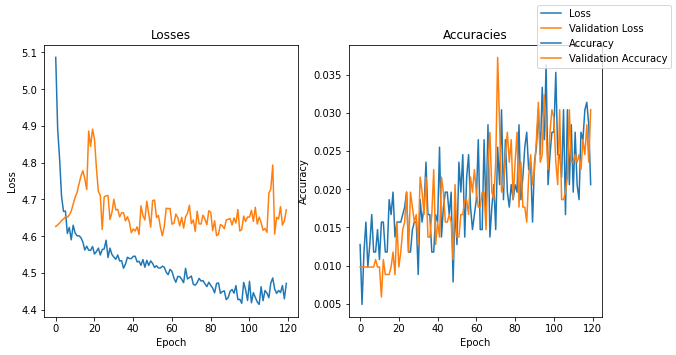

In [15]:
history = {'loss': [5.086607, 4.891028, 4.8105, 4.708412, 4.667637, 4.668048, 4.607385, 4.623818, 4.590005, 4.629722, 4.608683, 4.600798, 4.601169, 4.59583, 4.584163, 4.56228, 4.572638, 4.561872, 4.561254, 4.571932, 4.551338, 4.557903, 4.567478, 4.548749, 4.563562, 4.565157, 4.588894, 4.541884, 4.5674, 4.55, 4.543119, 4.536981, 4.548764, 4.532374, 4.533117, 4.512661, 4.524113, 4.542648, 4.53928, 4.538929, 4.545011, 4.545416, 4.530054, 4.531574, 4.520584, 4.536413, 4.51542, 4.534223, 4.520367, 4.532617, 4.525941, 4.514729, 4.51959, 4.513301, 4.513412, 4.51804, 4.515697, 4.501948, 4.495141, 4.509619, 4.503923, 4.48602, 4.474618, 4.490482, 4.489851, 4.48263, 4.473358, 4.512384, 4.483433, 4.487516, 4.4915, 4.469053, 4.466578, 4.473519, 4.484977, 4.477784, 4.478937, 4.470525, 4.462652, 4.474607, 4.466379, 4.458621, 4.445833, 4.471166, 4.472764, 4.444281, 4.449082, 4.451083, 4.427259, 4.432781, 4.449745, 4.454885, 4.444834, 4.465352, 4.427247, 4.42814, 4.417213, 4.474117, 4.453881, 4.424933, 4.476944, 4.418689, 4.44616, 4.433253, 4.421053, 4.414151, 4.46243, 4.424349, 4.452108, 4.445038, 4.432463, 4.472701, 4.486156, 4.456181, 4.444152, 4.452184, 4.44653, 4.465623, 4.429575, 4.471505], 'accuracy': [0.012745, 0.004902, 0.011765, 0.015686, 0.009804, 0.012745, 0.016667, 0.011765, 0.011765, 0.014706, 0.010784, 0.015686, 0.015686, 0.011765, 0.011765, 0.018627, 0.016667, 0.019608, 0.013725, 0.015686, 0.015686, 0.015686, 0.016667, 0.017647, 0.019608, 0.011765, 0.011765, 0.014706, 0.015686, 0.015686, 0.008824, 0.018627, 0.015686, 0.017647, 0.023529, 0.016667, 0.016667, 0.011765, 0.011765, 0.016667, 0.015686, 0.02549, 0.013725, 0.017647, 0.019608, 0.019608, 0.016667, 0.019608, 0.007843, 0.017647, 0.012745, 0.023529, 0.019608, 0.02451, 0.013725, 0.021569, 0.02451, 0.017647, 0.014706, 0.016667, 0.018627, 0.026471, 0.014706, 0.014706, 0.026471, 0.016667, 0.028431, 0.013725, 0.017647, 0.020588, 0.014706, 0.02549, 0.020588, 0.030392, 0.018627, 0.026471, 0.019608, 0.017647, 0.020588, 0.018627, 0.020588, 0.019608, 0.028431, 0.018627, 0.021569, 0.02549, 0.027451, 0.022549, 0.023529, 0.015686, 0.023529, 0.02549, 0.030392, 0.02451, 0.033333, 0.026471, 0.036275, 0.020588, 0.02451, 0.027451, 0.027451, 0.035294, 0.02451, 0.02451, 0.021569, 0.030392, 0.016667, 0.030392, 0.020588, 0.028431, 0.019608, 0.027451, 0.020588, 0.018627, 0.027451, 0.026471, 0.030392, 0.031373, 0.028431, 0.020588], 'val_loss': [4.626326, 4.63062, 4.635654, 4.642103, 4.646683, 4.652645, 4.651061, 4.657796, 4.667763, 4.686968, 4.705644, 4.718877, 4.741728, 4.763182, 4.778108, 4.756696, 4.726862, 4.886054, 4.843894, 4.891243, 4.863743, 4.785094, 4.722126, 4.71072, 4.618298, 4.706527, 4.710077, 4.71031, 4.645178, 4.664491, 4.700613, 4.671383, 4.672904, 4.652552, 4.663566, 4.663706, 4.641615, 4.652676, 4.638361, 4.609532, 4.619546, 4.613894, 4.62533, 4.604316, 4.682426, 4.656075, 4.644166, 4.695048, 4.660466, 4.62442, 4.696877, 4.698255, 4.65069, 4.656452, 4.625062, 4.601114, 4.625152, 4.676119, 4.674817, 4.675453, 4.632724, 4.634773, 4.659993, 4.650397, 4.628004, 4.651185, 4.621832, 4.65242, 4.662443, 4.684025, 4.634041, 4.644066, 4.612929, 4.667909, 4.633537, 4.633047, 4.657104, 4.646379, 4.630963, 4.669167, 4.664824, 4.614663, 4.641692, 4.601323, 4.605618, 4.631657, 4.628471, 4.620119, 4.643978, 4.6459, 4.647717, 4.630309, 4.649545, 4.635818, 4.672568, 4.613959, 4.618248, 4.654753, 4.639708, 4.652062, 4.651803, 4.670183, 4.640388, 4.678689, 4.633212, 4.651684, 4.637454, 4.615968, 4.620916, 4.610462, 4.717381, 4.728336, 4.793654, 4.605659, 4.651418, 4.646565, 4.68029, 4.630121, 4.641466, 4.671687], 'val_accuracy': [0.009804, 0.009804, 0.009804, 0.009804, 0.009804, 0.009804, 0.009804, 0.009804, 0.010784, 0.009804, 0.009804, 0.005882, 0.010784, 0.008824, 0.008824, 0.008824, 0.009804, 0.011765, 0.008824, 0.015686, 0.009804, 0.011765, 0.014706, 0.015686, 0.019608, 0.011765, 0.019608, 0.017647, 0.015686, 0.016667, 0.012745, 0.021569, 0.019608, 0.016667, 0.021569, 0.013725, 0.013725, 0.016667, 0.022549, 0.012745, 0.015686, 0.013725, 0.021569, 0.019608, 0.015686, 0.015686, 0.016667, 0.015686, 0.010784, 0.020588, 0.013725, 0.013725, 0.016667, 0.016667, 0.018627, 0.018627, 0.016667, 0.021569, 0.019608, 0.022549, 0.019608, 0.017647, 0.017647, 0.019608, 0.019608, 0.014706, 0.023529, 0.027451, 0.019608, 0.018627, 0.023529, 0.037255, 0.028431, 0.019608, 0.020588, 0.02451, 0.027451, 0.023529, 0.026471, 0.018627, 0.023529, 0.027451, 0.017647, 0.023529, 0.017647, 0.017647, 0.015686, 0.021569, 0.02451, 0.020588, 0.022549, 0.026471, 0.031373, 0.023529, 0.02451, 0.032353, 0.027451, 0.022549, 0.027451, 0.030392, 0.029412, 0.023529, 0.020588, 0.030392, 0.018627, 0.018627, 0.019608, 0.021569, 0.030392, 0.023529, 0.023529, 0.02451, 0.023529, 0.02451, 0.022549, 0.026471, 0.02451, 0.028431, 0.023529, 0.030392]}

plot_history(history)
print(max(history['accuracy']), '|', max(history['val_accuracy']))

## Model 7 (depth=30, skips=[2, 3, 5, 8, 13, 21])

0.134314 | 0.094118


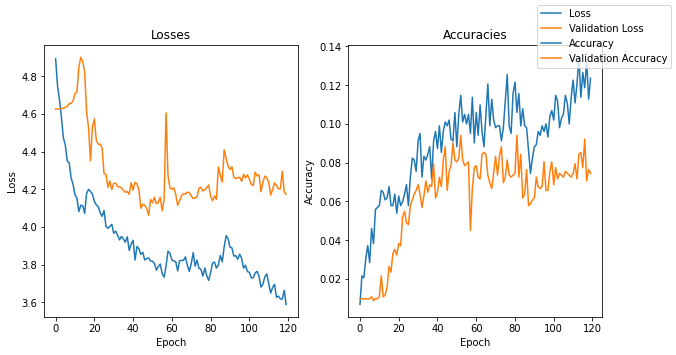

In [16]:
history = {'loss': [4.89319, 4.748472, 4.674715, 4.581836, 4.474596, 4.435531, 4.350806, 4.341587, 4.260673, 4.226339, 4.171782, 4.153233, 4.082014, 4.115816, 4.112966, 4.072747, 4.179003, 4.199831, 4.188788, 4.175401, 4.136713, 4.117488, 4.108925, 4.076506, 4.05667, 4.087366, 4.003995, 3.993302, 4.003372, 4.013997, 3.967226, 3.978596, 3.956987, 3.932001, 3.950158, 3.935851, 3.919649, 3.948306, 3.875764, 3.909902, 3.92994, 3.825122, 3.897415, 3.884278, 3.855343, 3.866032, 3.824916, 3.832913, 3.835671, 3.820174, 3.818907, 3.806987, 3.771234, 3.790526, 3.803489, 3.752725, 3.734184, 3.791926, 3.872354, 3.861012, 3.826539, 3.818668, 3.816846, 3.767223, 3.821784, 3.823178, 3.823016, 3.841707, 3.796979, 3.765137, 3.805636, 3.864723, 3.792702, 3.824722, 3.781343, 3.776093, 3.739763, 3.782628, 3.741928, 3.716815, 3.758336, 3.809286, 3.814099, 3.782213, 3.798878, 3.849283, 3.815409, 3.894301, 3.954411, 3.939066, 3.893346, 3.889401, 3.846056, 3.847886, 3.830166, 3.856184, 3.834092, 3.782107, 3.79715, 3.763752, 3.759734, 3.730277, 3.730864, 3.756003, 3.765157, 3.737581, 3.681499, 3.697661, 3.736296, 3.751325, 3.699051, 3.649718, 3.679616, 3.696214, 3.627156, 3.633719, 3.618989, 3.617933, 3.664513, 3.589396], 'accuracy': [0.006863, 0.021569, 0.020588, 0.030392, 0.037255, 0.028431, 0.046078, 0.038235, 0.055882, 0.056863, 0.057843, 0.065686, 0.064706, 0.060784, 0.061765, 0.067647, 0.057843, 0.057843, 0.063725, 0.053922, 0.062745, 0.057843, 0.059804, 0.063725, 0.068627, 0.057843, 0.072549, 0.082353, 0.081373, 0.07549, 0.091176, 0.095098, 0.072549, 0.083333, 0.081373, 0.084314, 0.088235, 0.071569, 0.091176, 0.096078, 0.087255, 0.09902, 0.085294, 0.096078, 0.10098, 0.09902, 0.101961, 0.092157, 0.091176, 0.105882, 0.088235, 0.104902, 0.114706, 0.10098, 0.104902, 0.1, 0.104902, 0.095098, 0.113725, 0.090196, 0.105882, 0.094118, 0.109804, 0.096078, 0.088235, 0.104902, 0.120588, 0.09902, 0.112745, 0.101961, 0.098039, 0.09902, 0.09902, 0.091176, 0.098039, 0.111765, 0.12549, 0.09902, 0.095098, 0.115686, 0.121569, 0.105882, 0.115686, 0.09902, 0.107843, 0.09902, 0.098039, 0.086275, 0.07451, 0.082353, 0.088235, 0.089216, 0.096078, 0.094118, 0.09902, 0.096078, 0.1, 0.093137, 0.103922, 0.106863, 0.101961, 0.114706, 0.111765, 0.098039, 0.102941, 0.104902, 0.114706, 0.110784, 0.1, 0.113725, 0.122549, 0.110784, 0.120588, 0.134314, 0.113725, 0.126471, 0.118627, 0.132353, 0.112745, 0.123529], 'val_loss': [4.625312, 4.626233, 4.627368, 4.628398, 4.630377, 4.634328, 4.64099, 4.654519, 4.655835, 4.6695, 4.708912, 4.715391, 4.849381, 4.900312, 4.877799, 4.822409, 4.611162, 4.526411, 4.351426, 4.531445, 4.573833, 4.460775, 4.439425, 4.440091, 4.419261, 4.283057, 4.278862, 4.210562, 4.24494, 4.19893, 4.231928, 4.23245, 4.21445, 4.213881, 4.207698, 4.194581, 4.184648, 4.18801, 4.173934, 4.23514, 4.196141, 4.237589, 4.229328, 4.196502, 4.099384, 4.120906, 4.116441, 4.099752, 4.062182, 4.146082, 4.128891, 4.158196, 4.124437, 4.130949, 4.158114, 4.085565, 4.14671, 4.605816, 4.275327, 4.208591, 4.200085, 4.208328, 4.173362, 4.115704, 4.139313, 4.165803, 4.177214, 4.175583, 4.184608, 4.1838, 4.165493, 4.150487, 4.154879, 4.160483, 4.206968, 4.211187, 4.191308, 4.197796, 4.208929, 4.223096, 4.161884, 4.139555, 4.164786, 4.146377, 4.317959, 4.27507, 4.238742, 4.409851, 4.363943, 4.324187, 4.305372, 4.320487, 4.264472, 4.256396, 4.2624, 4.2639, 4.243307, 4.279937, 4.261032, 4.277226, 4.253881, 4.227236, 4.220273, 4.291605, 4.271335, 4.276573, 4.187117, 4.238476, 4.270308, 4.261165, 4.236718, 4.169761, 4.198946, 4.234412, 4.2195, 4.203311, 4.202725, 4.296415, 4.185305, 4.174029], 'val_accuracy': [0.009804, 0.009804, 0.009804, 0.009804, 0.009804, 0.009804, 0.010784, 0.008824, 0.009804, 0.009804, 0.010784, 0.021569, 0.010784, 0.011765, 0.015686, 0.026471, 0.023529, 0.033333, 0.035294, 0.032353, 0.038235, 0.037255, 0.051961, 0.054902, 0.04902, 0.048039, 0.057843, 0.060784, 0.063725, 0.065686, 0.068627, 0.063725, 0.056863, 0.062745, 0.070588, 0.064706, 0.068627, 0.067647, 0.079412, 0.061765, 0.064706, 0.072549, 0.067647, 0.081373, 0.088235, 0.065686, 0.07549, 0.078431, 0.090196, 0.081373, 0.080392, 0.082353, 0.094118, 0.081373, 0.078431, 0.079412, 0.080392, 0.045098, 0.066667, 0.077451, 0.078431, 0.072549, 0.071569, 0.084314, 0.085294, 0.084314, 0.073529, 0.069608, 0.066667, 0.07451, 0.083333, 0.073529, 0.083333, 0.088235, 0.069608, 0.072549, 0.081373, 0.073529, 0.072549, 0.073529, 0.07451, 0.094118, 0.072549, 0.084314, 0.061765, 0.063725, 0.076471, 0.057843, 0.058824, 0.060784, 0.061765, 0.072549, 0.067647, 0.066667, 0.067647, 0.080392, 0.065686, 0.065686, 0.07549, 0.080392, 0.068627, 0.077451, 0.071569, 0.07451, 0.073529, 0.072549, 0.07549, 0.07451, 0.073529, 0.072549, 0.07451, 0.079412, 0.071569, 0.084314, 0.085294, 0.077451, 0.092157, 0.070588, 0.076471, 0.07451]}

plot_history(history)
print(max(history['accuracy']), '|', max(history['val_accuracy']))

## Model 8 (depth=30, skips=[2, 3, 5, 8, 13, 21])

0.041176 | 0.035294


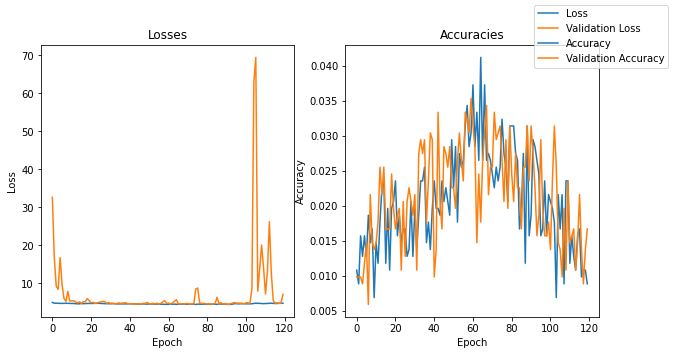

In [17]:
history = {'loss': [5.018319, 4.779753, 4.802488, 4.775996, 4.74552, 4.758286, 4.744069, 4.775954, 4.760247, 4.742341, 4.722905, 4.740964, 4.649823, 4.641815, 4.636615, 4.707096, 4.67471, 4.691229, 4.730086, 4.740242, 4.725834, 4.740756, 4.752261, 4.759723, 4.780746, 4.726988, 4.710612, 4.678868, 4.666587, 4.670634, 4.638478, 4.673852, 4.689576, 4.604233, 4.620131, 4.601905, 4.62193, 4.597948, 4.611623, 4.629493, 4.646375, 4.59472, 4.618809, 4.574564, 4.581422, 4.564669, 4.563642, 4.610848, 4.580721, 4.552442, 4.593291, 4.557953, 4.609929, 4.500214, 4.57601, 4.555871, 4.510363, 4.53485, 4.491439, 4.482675, 4.515558, 4.555814, 4.524419, 4.549991, 4.494314, 4.528429, 4.542193, 4.540282, 4.541557, 4.527471, 4.540826, 4.521359, 4.522701, 4.535301, 4.467257, 4.559382, 4.540923, 4.506108, 4.564288, 4.514729, 4.507807, 4.524325, 4.481069, 4.542775, 4.521578, 4.500359, 4.59283, 4.576167, 4.538449, 4.605937, 4.502556, 4.494589, 4.480803, 4.543866, 4.686048, 4.642325, 4.626705, 4.637412, 4.667173, 4.652041, 4.63263, 4.63566, 4.626862, 4.650987, 4.732451, 4.787997, 4.760582, 4.753429, 4.714588, 4.670189, 4.708257, 4.738136, 4.756654, 4.81454, 4.732295, 4.73491, 4.709717, 4.782801, 4.777371, 4.790549], 'accuracy': [0.010784, 0.008824, 0.015686, 0.012745, 0.015686, 0.012745, 0.018627, 0.014706, 0.016667, 0.006863, 0.014706, 0.011765, 0.017647, 0.022549, 0.023529, 0.011765, 0.019608, 0.010784, 0.019608, 0.020588, 0.023529, 0.015686, 0.018627, 0.014706, 0.016667, 0.016667, 0.012745, 0.013725, 0.020588, 0.012745, 0.019608, 0.013725, 0.018627, 0.023529, 0.023529, 0.02549, 0.014706, 0.017647, 0.013725, 0.019608, 0.023529, 0.019608, 0.019608, 0.018627, 0.023529, 0.020588, 0.022549, 0.020588, 0.018627, 0.029412, 0.022549, 0.028431, 0.017647, 0.027451, 0.02549, 0.026471, 0.031373, 0.034314, 0.028431, 0.030392, 0.037255, 0.028431, 0.033333, 0.026471, 0.041176, 0.026471, 0.037255, 0.026471, 0.027451, 0.026471, 0.02451, 0.022549, 0.02549, 0.023529, 0.02549, 0.032353, 0.027451, 0.02549, 0.020588, 0.031373, 0.031373, 0.031373, 0.027451, 0.026471, 0.016667, 0.019608, 0.027451, 0.011765, 0.031373, 0.015686, 0.018627, 0.029412, 0.028431, 0.026471, 0.02451, 0.015686, 0.016667, 0.023529, 0.015686, 0.021569, 0.020588, 0.019608, 0.017647, 0.006863, 0.021569, 0.016667, 0.021569, 0.008824, 0.023529, 0.023529, 0.011765, 0.015686, 0.012745, 0.010784, 0.015686, 0.016667, 0.009804, 0.010784, 0.010784, 0.008824], 'val_loss': [32.647339, 16.852898, 9.305022, 8.426834, 16.759232, 9.794376, 6.063621, 5.256626, 7.928391, 5.362111, 5.441419, 5.448738, 5.141125, 4.86142, 5.158536, 4.721582, 5.194083, 5.174717, 6.01574, 5.48115, 4.901421, 5.002525, 4.777328, 4.831126, 5.034332, 5.135834, 5.267183, 5.211328, 4.752306, 4.960628, 4.774394, 4.813505, 4.66797, 4.592009, 4.895043, 4.751924, 4.803123, 4.866985, 4.902477, 4.668949, 4.658471, 4.700261, 4.582715, 4.586608, 4.57607, 4.649817, 4.58282, 4.764093, 4.785077, 4.982596, 4.662374, 4.57453, 4.78883, 4.589334, 4.809214, 4.569542, 4.736009, 5.182258, 5.430211, 4.759276, 4.838012, 4.569517, 4.85003, 5.298418, 5.728078, 4.640728, 4.650486, 4.654794, 4.579152, 4.708127, 4.706294, 4.5505, 4.623923, 4.583755, 8.499419, 8.788205, 4.927567, 4.699174, 4.766953, 4.657785, 4.583264, 4.582983, 4.580199, 4.614234, 4.696314, 6.344117, 4.638328, 4.926001, 4.577174, 4.735002, 4.560447, 4.480626, 4.657842, 4.845149, 4.924364, 4.823381, 4.812016, 4.777755, 4.792552, 4.650595, 4.90894, 4.853524, 4.795535, 8.581131, 63.020199, 69.444809, 7.944332, 13.740808, 20.098265, 14.075443, 7.198413, 13.093271, 26.242802, 12.700982, 5.479875, 4.81461, 4.889169, 4.746357, 4.761895, 7.134878], 'val_accuracy': [0.009804, 0.009804, 0.009804, 0.008824, 0.011765, 0.014706, 0.005882, 0.021569, 0.014706, 0.013725, 0.014706, 0.017647, 0.02549, 0.021569, 0.02549, 0.016667, 0.016667, 0.016667, 0.02451, 0.019608, 0.016667, 0.018627, 0.019608, 0.010784, 0.020588, 0.012745, 0.020588, 0.022549, 0.020588, 0.018627, 0.021569, 0.010784, 0.027451, 0.029412, 0.027451, 0.029412, 0.017647, 0.023529, 0.030392, 0.029412, 0.009804, 0.013725, 0.033333, 0.020588, 0.016667, 0.028431, 0.027451, 0.02549, 0.028431, 0.022549, 0.022549, 0.019608, 0.026471, 0.030392, 0.026471, 0.023529, 0.033333, 0.032353, 0.030392, 0.035294, 0.031373, 0.028431, 0.014706, 0.02451, 0.017647, 0.026471, 0.030392, 0.034314, 0.021569, 0.02549, 0.02549, 0.033333, 0.029412, 0.030392, 0.031373, 0.026471, 0.020588, 0.029412, 0.019608, 0.031373, 0.02451, 0.020588, 0.027451, 0.022549, 0.022549, 0.016667, 0.02549, 0.02549, 0.031373, 0.023529, 0.031373, 0.027451, 0.022549, 0.015686, 0.018627, 0.029412, 0.019608, 0.015686, 0.015686, 0.017647, 0.013725, 0.023529, 0.031373, 0.02549, 0.014706, 0.013725, 0.009804, 0.019608, 0.010784, 0.023529, 0.014706, 0.015686, 0.016667, 0.010784, 0.014706, 0.021569, 0.013725, 0.008824, 0.013725, 0.016667]}

plot_history(history)
print(max(history['accuracy']), '|', max(history['val_accuracy']))

## Model 10 (depth=20, skips=[2, 3, 5, 8, 13])

0.182353 | 0.083333


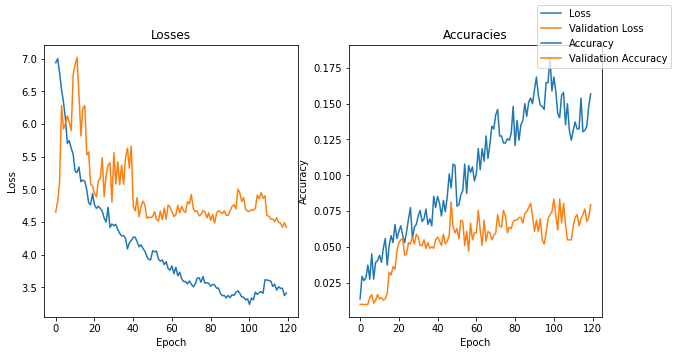

In [18]:
history = {'loss': [6.940204, 7.002898, 6.784101, 6.526034, 6.339378, 6.080689, 5.702124, 5.745649, 5.627224, 5.536824, 5.274893, 5.257538, 5.342301, 5.116095, 5.140645, 5.121687, 4.993644, 4.794036, 4.761634, 4.935325, 4.762495, 4.707802, 4.740272, 4.708177, 4.664823, 4.559032, 4.496655, 4.72429, 4.4165, 4.468568, 4.442174, 4.462479, 4.383713, 4.324912, 4.287296, 4.289674, 4.250465, 4.086909, 4.180121, 4.213561, 4.265695, 4.266548, 4.19797, 4.120072, 4.150098, 4.094834, 4.051987, 3.971443, 3.925952, 3.919888, 4.057845, 4.041041, 4.053149, 3.932688, 3.899347, 3.918228, 3.844831, 3.890835, 3.786227, 3.760092, 3.825287, 3.706306, 3.805942, 3.672983, 3.728793, 3.62766, 3.586881, 3.586058, 3.550383, 3.594558, 3.54523, 3.506837, 3.548215, 3.639202, 3.642845, 3.576254, 3.663532, 3.560896, 3.567774, 3.559167, 3.515053, 3.54264, 3.534796, 3.482798, 3.486548, 3.40355, 3.369373, 3.373264, 3.335808, 3.372968, 3.340362, 3.385139, 3.373716, 3.422683, 3.444773, 3.406734, 3.349534, 3.345654, 3.305927, 3.322388, 3.235415, 3.334422, 3.304423, 3.424141, 3.389128, 3.416719, 3.43182, 3.406692, 3.614195, 3.608709, 3.60321, 3.592753, 3.512208, 3.546088, 3.455436, 3.506756, 3.482839, 3.483637, 3.371015, 3.408784], 'accuracy': [0.013725, 0.029412, 0.026471, 0.028431, 0.037255, 0.027451, 0.045098, 0.027451, 0.039216, 0.040196, 0.044118, 0.039216, 0.04902, 0.055882, 0.037255, 0.05098, 0.057843, 0.052941, 0.065686, 0.055882, 0.060784, 0.064706, 0.057843, 0.052941, 0.060784, 0.069608, 0.077451, 0.055882, 0.063725, 0.065686, 0.071569, 0.07549, 0.067647, 0.069608, 0.076471, 0.065686, 0.069608, 0.064706, 0.085294, 0.077451, 0.085294, 0.080392, 0.071569, 0.082353, 0.07451, 0.085294, 0.10098, 0.091176, 0.107843, 0.106863, 0.078431, 0.079412, 0.086275, 0.089216, 0.107843, 0.087255, 0.106863, 0.101961, 0.105882, 0.096078, 0.10098, 0.118627, 0.103922, 0.118627, 0.109804, 0.127451, 0.111765, 0.121569, 0.134314, 0.132353, 0.142157, 0.146078, 0.127451, 0.127451, 0.122549, 0.122549, 0.12549, 0.12451, 0.129412, 0.148039, 0.120588, 0.138235, 0.12451, 0.135294, 0.138235, 0.15, 0.141176, 0.15098, 0.153922, 0.15, 0.159804, 0.168627, 0.155882, 0.14902, 0.148039, 0.146078, 0.164706, 0.164706, 0.182353, 0.158824, 0.168627, 0.158824, 0.143137, 0.140196, 0.155882, 0.157843, 0.135294, 0.15, 0.131373, 0.12451, 0.131373, 0.137255, 0.132353, 0.132353, 0.153922, 0.130392, 0.131373, 0.134314, 0.148039, 0.156863], 'val_loss': [4.651115, 4.814884, 5.115777, 6.284649, 5.923137, 6.007481, 6.125083, 6.031417, 5.903734, 6.75604, 6.908544, 7.022505, 6.452855, 5.817385, 6.245041, 6.286623, 5.52632, 5.572699, 5.078659, 5.050117, 4.937332, 4.882754, 5.134053, 5.171484, 5.483562, 4.889366, 5.219658, 5.368108, 5.406523, 4.803712, 5.56194, 5.084082, 5.421613, 5.072665, 5.371349, 5.074384, 5.475353, 5.631331, 5.322906, 5.663823, 4.743503, 4.669759, 4.874737, 4.579206, 4.730824, 4.81766, 4.765118, 4.556639, 4.575018, 4.566443, 4.579643, 4.657675, 4.539955, 4.513513, 4.66374, 4.535061, 4.712255, 4.54031, 4.757336, 4.730162, 4.65991, 4.583112, 4.609755, 4.753982, 4.639436, 4.739721, 4.670716, 4.644306, 4.811457, 4.776536, 4.920889, 4.702613, 4.659714, 4.670702, 4.593781, 4.61336, 4.675054, 4.655025, 4.561477, 4.639565, 4.524003, 4.616895, 4.482769, 4.632099, 4.671894, 4.654536, 4.626021, 4.671453, 4.602194, 4.599741, 4.676706, 4.736252, 4.765104, 4.698506, 5.001764, 4.943662, 4.8141, 4.87464, 4.689519, 4.664718, 4.659949, 4.688707, 4.678889, 4.706817, 4.908169, 4.853237, 4.950951, 4.859975, 4.90093, 4.598701, 4.586836, 4.541528, 4.544498, 4.504681, 4.566061, 4.494113, 4.481194, 4.418008, 4.489461, 4.417152], 'val_accuracy': [0.009804, 0.009804, 0.009804, 0.009804, 0.009804, 0.014706, 0.016667, 0.010784, 0.012745, 0.016667, 0.013725, 0.014706, 0.012745, 0.013725, 0.017647, 0.032353, 0.030392, 0.036275, 0.034314, 0.047059, 0.052941, 0.054902, 0.055882, 0.044118, 0.045098, 0.052941, 0.051961, 0.056863, 0.051961, 0.058824, 0.056863, 0.05098, 0.05098, 0.054902, 0.04902, 0.052941, 0.04902, 0.05, 0.04902, 0.054902, 0.056863, 0.053922, 0.05098, 0.058824, 0.051961, 0.053922, 0.057843, 0.081373, 0.063725, 0.059804, 0.062745, 0.055882, 0.068627, 0.067647, 0.05098, 0.060784, 0.047059, 0.066667, 0.054902, 0.059804, 0.059804, 0.07549, 0.061765, 0.05098, 0.068627, 0.053922, 0.060784, 0.059804, 0.054902, 0.057843, 0.059804, 0.072549, 0.064706, 0.063725, 0.07549, 0.071569, 0.059804, 0.063725, 0.062745, 0.067647, 0.068627, 0.068627, 0.070588, 0.070588, 0.066667, 0.073529, 0.07451, 0.077451, 0.080392, 0.071569, 0.060784, 0.068627, 0.060784, 0.069608, 0.054902, 0.051961, 0.059804, 0.069608, 0.072549, 0.07451, 0.083333, 0.072549, 0.061765, 0.083333, 0.066667, 0.080392, 0.065686, 0.054902, 0.054902, 0.054902, 0.064706, 0.070588, 0.072549, 0.064706, 0.069608, 0.072549, 0.076471, 0.067647, 0.070588, 0.079412]}
plot_history(history)
print(max(history['accuracy']), '|', max(history['val_accuracy']))

## Model 11 (depth=30, skips=[2, 3, 5, 8, 13, 21])
* Uses Conv Merge

0.079412 | 0.055882


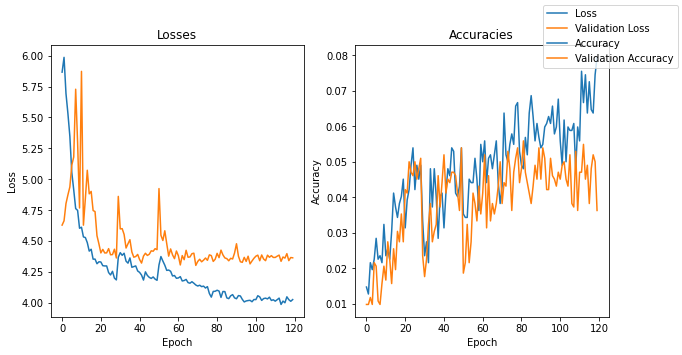

In [19]:
history = {'loss': [5.866611, 5.986466, 5.693815, 5.531745, 5.348197, 5.0545, 4.914179, 4.762941, 4.748116, 4.603439, 4.611916, 4.533374, 4.528438, 4.486985, 4.418464, 4.433768, 4.353338, 4.353845, 4.316489, 4.332121, 4.330582, 4.30052, 4.298563, 4.298521, 4.245007, 4.225518, 4.254998, 4.199982, 4.185589, 4.3685, 4.406151, 4.384432, 4.401584, 4.337368, 4.321167, 4.363352, 4.287633, 4.293253, 4.298619, 4.257904, 4.246351, 4.224438, 4.184179, 4.250708, 4.221687, 4.205845, 4.197616, 4.209483, 4.191937, 4.182221, 4.306802, 4.374598, 4.338168, 4.304595, 4.262655, 4.265309, 4.255359, 4.217422, 4.220952, 4.198682, 4.201245, 4.212051, 4.176865, 4.18054, 4.189457, 4.163688, 4.158689, 4.170909, 4.1587, 4.14431, 4.136045, 4.142623, 4.131215, 4.135197, 4.11981, 4.131111, 4.075687, 4.046198, 4.09236, 4.093594, 4.101944, 4.095336, 4.04395, 4.09168, 4.090886, 4.040012, 4.033986, 4.056805, 4.066476, 4.040143, 4.033004, 4.058699, 4.055569, 4.028018, 4.007383, 4.015224, 4.01852, 4.020333, 4.00886, 4.026878, 4.026116, 4.057587, 4.047835, 4.01969, 4.03443, 4.037948, 4.031868, 4.045723, 4.01938, 4.024822, 4.013637, 4.025424, 4.0383, 3.986954, 4.014225, 4.000497, 4.048674, 4.025579, 4.012519, 4.026234], 'accuracy': [0.014706, 0.012745, 0.021569, 0.019608, 0.022549, 0.028431, 0.022549, 0.023529, 0.021569, 0.032353, 0.023529, 0.02549, 0.022549, 0.030392, 0.041176, 0.037255, 0.034314, 0.038235, 0.040196, 0.045098, 0.031373, 0.039216, 0.042157, 0.04902, 0.053922, 0.042157, 0.04902, 0.045098, 0.04902, 0.033333, 0.023529, 0.027451, 0.021569, 0.048039, 0.037255, 0.048039, 0.040196, 0.028431, 0.040196, 0.041176, 0.031373, 0.041176, 0.048039, 0.046078, 0.053922, 0.052941, 0.041176, 0.040196, 0.043137, 0.053922, 0.035294, 0.034314, 0.034314, 0.045098, 0.044118, 0.044118, 0.05098, 0.045098, 0.036275, 0.054902, 0.05, 0.055882, 0.044118, 0.05098, 0.051961, 0.048039, 0.051961, 0.055882, 0.044118, 0.038235, 0.043137, 0.063725, 0.051961, 0.05, 0.054902, 0.057843, 0.054902, 0.065686, 0.066667, 0.052941, 0.04902, 0.048039, 0.056863, 0.051961, 0.063725, 0.068627, 0.062745, 0.055882, 0.060784, 0.056863, 0.053922, 0.054902, 0.059804, 0.060784, 0.062745, 0.060784, 0.065686, 0.057843, 0.059804, 0.067647, 0.055882, 0.04902, 0.061765, 0.05, 0.059804, 0.058824, 0.058824, 0.060784, 0.048039, 0.059804, 0.055882, 0.07549, 0.066667, 0.07451, 0.063725, 0.072549, 0.064706, 0.063725, 0.07451, 0.079412], 'val_loss': [4.628933, 4.663774, 4.80317, 4.873614, 4.937685, 5.114433, 5.180275, 5.72859, 5.296259, 4.76743, 5.87298, 4.628457, 4.843412, 5.073045, 4.882081, 4.901689, 4.746908, 4.738619, 4.543138, 4.477118, 4.40391, 4.432523, 4.403654, 4.404356, 4.438665, 4.388883, 4.390574, 4.433818, 4.362976, 4.861298, 4.598218, 4.600385, 4.553518, 4.443452, 4.478133, 4.51095, 4.411345, 4.369209, 4.374806, 4.391713, 4.350201, 4.321772, 4.378219, 4.401244, 4.383451, 4.393385, 4.420859, 4.41774, 4.438173, 4.430201, 4.92458, 4.546896, 4.504485, 4.583047, 4.4791, 4.37794, 4.436018, 4.388044, 4.357508, 4.419444, 4.381517, 4.306558, 4.382335, 4.349058, 4.425268, 4.368777, 4.371519, 4.397568, 4.401779, 4.302866, 4.334894, 4.352465, 4.332059, 4.345401, 4.362664, 4.343892, 4.388277, 4.382218, 4.335007, 4.352758, 4.400578, 4.365473, 4.426558, 4.387881, 4.363371, 4.357911, 4.340279, 4.360326, 4.354974, 4.403349, 4.478178, 4.377765, 4.332533, 4.327694, 4.36794, 4.335213, 4.377372, 4.31506, 4.338732, 4.360327, 4.377596, 4.385763, 4.340635, 4.387261, 4.354486, 4.341194, 4.385799, 4.368563, 4.381855, 4.367323, 4.367476, 4.377456, 4.386176, 4.335989, 4.370876, 4.362085, 4.397976, 4.341549, 4.366626, 4.364275], 'val_accuracy': [0.009804, 0.009804, 0.011765, 0.009804, 0.021569, 0.020588, 0.010784, 0.009804, 0.015686, 0.020588, 0.016667, 0.027451, 0.022549, 0.015686, 0.02549, 0.019608, 0.030392, 0.027451, 0.035294, 0.027451, 0.042157, 0.041176, 0.05, 0.047059, 0.046078, 0.05, 0.045098, 0.048039, 0.05098, 0.023529, 0.017647, 0.022549, 0.032353, 0.038235, 0.027451, 0.030392, 0.032353, 0.046078, 0.037255, 0.044118, 0.051961, 0.041176, 0.045098, 0.044118, 0.047059, 0.047059, 0.046078, 0.041176, 0.036275, 0.053922, 0.018627, 0.021569, 0.032353, 0.021569, 0.027451, 0.041176, 0.038235, 0.033333, 0.043137, 0.035294, 0.041176, 0.051961, 0.031373, 0.046078, 0.033333, 0.038235, 0.035294, 0.038235, 0.043137, 0.05, 0.038235, 0.044118, 0.043137, 0.052941, 0.048039, 0.036275, 0.047059, 0.05098, 0.053922, 0.044118, 0.048039, 0.055882, 0.047059, 0.044118, 0.041176, 0.038235, 0.043137, 0.04902, 0.045098, 0.053922, 0.045098, 0.053922, 0.05098, 0.042157, 0.042157, 0.05098, 0.046078, 0.045098, 0.043137, 0.047059, 0.045098, 0.04902, 0.05, 0.045098, 0.043137, 0.051961, 0.038235, 0.037255, 0.052941, 0.036275, 0.047059, 0.047059, 0.054902, 0.045098, 0.04902, 0.038235, 0.048039, 0.051961, 0.05, 0.036275]}

plot_history(history)
print(max(history['accuracy']), '|', max(history['val_accuracy']))


## Model 12 (depth=30, skips=[2, 3, 5, 8, 13, 21])
* Uses Dense Merge

0.185294 | 0.089216


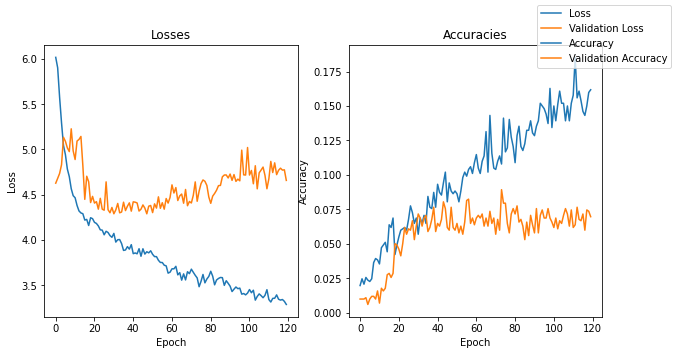

In [20]:
history = {'loss': [6.015894, 5.900825, 5.575938, 5.292697, 5.044319, 4.942483, 4.783807, 4.700113, 4.566978, 4.490133, 4.467162, 4.382183, 4.321878, 4.299568, 4.29094, 4.220905, 4.228153, 4.161135, 4.246659, 4.236358, 4.195755, 4.183529, 4.15624, 4.113066, 4.110096, 4.058498, 4.097252, 4.083723, 4.049861, 4.030771, 4.073817, 3.978166, 4.004461, 4.005783, 3.961231, 3.886083, 3.890865, 3.927771, 3.900445, 3.949588, 3.850421, 3.858187, 3.848899, 3.904911, 3.821562, 3.904393, 3.845587, 3.871548, 3.85919, 3.882108, 3.842995, 3.817919, 3.817778, 3.777169, 3.753211, 3.752674, 3.722704, 3.716101, 3.635473, 3.646072, 3.683441, 3.682965, 3.710595, 3.616582, 3.640886, 3.558267, 3.627316, 3.560688, 3.651298, 3.62972, 3.67934, 3.644833, 3.611681, 3.582685, 3.485706, 3.545867, 3.620921, 3.528394, 3.570902, 3.599214, 3.656217, 3.60212, 3.506569, 3.559863, 3.576679, 3.587711, 3.585622, 3.500665, 3.551907, 3.522945, 3.49165, 3.432332, 3.458516, 3.482734, 3.464061, 3.470294, 3.40362, 3.410676, 3.395911, 3.415549, 3.454465, 3.419413, 3.446895, 3.337657, 3.37804, 3.406459, 3.387028, 3.364351, 3.390811, 3.452921, 3.344301, 3.316866, 3.357511, 3.358222, 3.395463, 3.347714, 3.33819, 3.34476, 3.324317, 3.290164], 'accuracy': [0.019608, 0.02451, 0.020588, 0.02549, 0.023529, 0.022549, 0.02451, 0.036275, 0.039216, 0.038235, 0.035294, 0.047059, 0.04902, 0.05098, 0.044118, 0.063725, 0.061765, 0.068627, 0.042157, 0.04902, 0.054902, 0.059804, 0.060784, 0.061765, 0.059804, 0.067647, 0.077451, 0.072549, 0.064706, 0.068627, 0.056863, 0.068627, 0.064706, 0.070588, 0.064706, 0.084314, 0.076471, 0.07549, 0.087255, 0.076471, 0.093137, 0.087255, 0.085294, 0.094118, 0.101961, 0.080392, 0.094118, 0.088235, 0.086275, 0.088235, 0.086275, 0.080392, 0.088235, 0.098039, 0.101961, 0.09902, 0.103922, 0.105882, 0.10098, 0.108824, 0.114706, 0.104902, 0.10098, 0.109804, 0.113725, 0.131373, 0.101961, 0.143137, 0.115686, 0.104902, 0.103922, 0.109804, 0.113725, 0.107843, 0.141176, 0.116667, 0.119608, 0.140196, 0.127451, 0.120588, 0.108824, 0.128431, 0.135294, 0.120588, 0.117647, 0.122549, 0.132353, 0.132353, 0.139216, 0.130392, 0.128431, 0.135294, 0.139216, 0.151961, 0.15, 0.148039, 0.144118, 0.137255, 0.162745, 0.134314, 0.15, 0.139216, 0.15098, 0.160784, 0.151961, 0.151961, 0.139216, 0.15, 0.139216, 0.151961, 0.157843, 0.185294, 0.155882, 0.160784, 0.153922, 0.146078, 0.143137, 0.15, 0.159804, 0.161765], 'val_loss': [4.627974, 4.680903, 4.735023, 4.831739, 5.134456, 5.089382, 5.017103, 4.976289, 5.227515, 4.984959, 4.889005, 5.0928, 5.110307, 5.143511, 4.821533, 4.449454, 4.704485, 4.643034, 4.414062, 4.482258, 4.408204, 4.424108, 4.341455, 4.460896, 4.341353, 4.329812, 4.642344, 4.335189, 4.301862, 4.360102, 4.290412, 4.332961, 4.404238, 4.301114, 4.309831, 4.418189, 4.325501, 4.373901, 4.410888, 4.319384, 4.42214, 4.418212, 4.409889, 4.320298, 4.341056, 4.387923, 4.352644, 4.289942, 4.374397, 4.381658, 4.303286, 4.399817, 4.353086, 4.47717, 4.350617, 4.412477, 4.341023, 4.458548, 4.408125, 4.470556, 4.609345, 4.519488, 4.579195, 4.436503, 4.487694, 4.508008, 4.406933, 4.558453, 4.379143, 4.425945, 4.409428, 4.494512, 4.641959, 4.428424, 4.540409, 4.623711, 4.663584, 4.648619, 4.603005, 4.475445, 4.405708, 4.484723, 4.514583, 4.550246, 4.600704, 4.603069, 4.697789, 4.718046, 4.718679, 4.685128, 4.728647, 4.658999, 4.722695, 4.647643, 4.672843, 4.654042, 4.992322, 4.719851, 4.717705, 5.021373, 4.717676, 4.768123, 4.621274, 4.820329, 4.565541, 4.741817, 4.773018, 4.805477, 4.713447, 4.56618, 4.676413, 4.868036, 4.74528, 4.852143, 4.722189, 4.770218, 4.793365, 4.772024, 4.775234, 4.658586], 'val_accuracy': [0.009804, 0.009804, 0.009804, 0.010784, 0.005882, 0.009804, 0.011765, 0.011765, 0.009804, 0.015686, 0.006863, 0.017647, 0.015686, 0.017647, 0.027451, 0.028431, 0.02549, 0.028431, 0.05, 0.04902, 0.046078, 0.041176, 0.05, 0.061765, 0.056863, 0.060784, 0.059804, 0.066667, 0.052941, 0.062745, 0.071569, 0.068627, 0.062745, 0.068627, 0.070588, 0.058824, 0.061765, 0.067647, 0.076471, 0.058824, 0.064706, 0.062745, 0.067647, 0.080392, 0.07549, 0.061765, 0.059804, 0.076471, 0.061765, 0.059804, 0.064706, 0.057843, 0.062745, 0.056863, 0.065686, 0.081373, 0.082353, 0.064706, 0.068627, 0.063725, 0.068627, 0.070588, 0.068627, 0.071569, 0.062745, 0.068627, 0.062745, 0.073529, 0.064706, 0.068627, 0.056863, 0.067647, 0.059804, 0.089216, 0.079412, 0.079412, 0.064706, 0.057843, 0.071569, 0.07549, 0.071569, 0.077451, 0.065686, 0.067647, 0.062745, 0.052941, 0.065686, 0.055882, 0.070588, 0.063725, 0.057843, 0.07549, 0.057843, 0.070588, 0.07451, 0.068627, 0.068627, 0.07549, 0.068627, 0.065686, 0.061765, 0.068627, 0.060784, 0.066667, 0.064706, 0.070588, 0.07549, 0.071569, 0.062745, 0.07451, 0.061765, 0.063725, 0.076471, 0.067647, 0.066667, 0.071569, 0.059804, 0.07451, 0.073529, 0.069608]}

plot_history(history)
print(max(history['accuracy']), '|', max(history['val_accuracy']))

## Model 13 (depth=30, skips=[2, 3, 5, 8, 13])

0.131373 | 0.098039


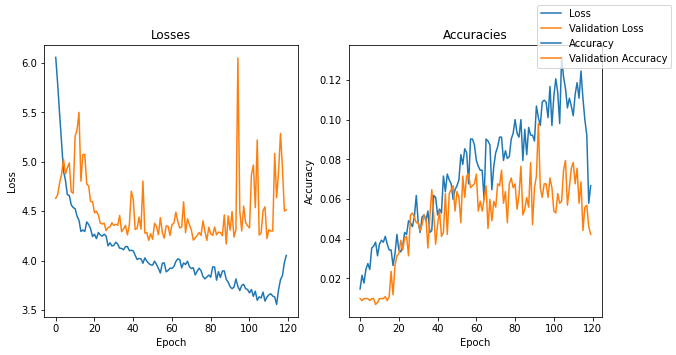

In [21]:
history = {'loss': [6.054215, 5.785926, 5.482844, 5.196342, 4.903621, 4.814833, 4.665305, 4.657789, 4.563179, 4.535764, 4.524893, 4.448732, 4.407328, 4.293612, 4.308867, 4.293216, 4.390233, 4.363356, 4.321597, 4.242415, 4.266517, 4.221354, 4.283732, 4.258945, 4.24683, 4.266548, 4.247328, 4.148732, 4.179712, 4.146996, 4.153595, 4.185728, 4.165442, 4.124728, 4.122862, 4.109126, 4.140209, 4.14167, 4.099525, 4.104393, 4.097873, 4.053221, 4.010542, 4.021713, 4.016195, 3.973129, 4.026817, 3.994184, 3.970705, 3.956261, 3.953622, 3.993676, 3.960386, 3.920689, 3.874067, 3.972203, 3.976675, 3.885864, 3.899912, 3.923632, 3.920359, 3.939577, 3.990419, 4.016676, 4.009859, 3.925329, 3.976515, 3.959809, 3.993507, 3.937474, 3.919184, 3.927308, 3.854149, 3.891754, 3.922504, 3.897025, 3.837827, 3.814434, 3.833303, 3.852973, 3.831594, 3.936492, 3.934212, 3.801324, 3.886952, 3.829486, 3.894344, 3.895128, 3.809984, 3.781684, 3.735099, 3.715419, 3.730964, 3.813891, 3.737773, 3.696958, 3.747626, 3.759792, 3.715926, 3.707093, 3.672711, 3.706959, 3.638744, 3.690042, 3.598272, 3.632962, 3.621426, 3.6814, 3.58976, 3.629637, 3.653083, 3.663971, 3.64043, 3.63203, 3.556142, 3.70465, 3.806488, 3.84698, 3.979234, 4.051758], 'accuracy': [0.014706, 0.021569, 0.017647, 0.02451, 0.027451, 0.02451, 0.035294, 0.036275, 0.038235, 0.031373, 0.037255, 0.039216, 0.038235, 0.041176, 0.037255, 0.034314, 0.034314, 0.026471, 0.032353, 0.042157, 0.034314, 0.033333, 0.036275, 0.043137, 0.042157, 0.04902, 0.048039, 0.046078, 0.05098, 0.061765, 0.048039, 0.043137, 0.05098, 0.051961, 0.04902, 0.053922, 0.043137, 0.044118, 0.061765, 0.060784, 0.051961, 0.054902, 0.052941, 0.071569, 0.063725, 0.072549, 0.069608, 0.067647, 0.059804, 0.064706, 0.066667, 0.069608, 0.082353, 0.077451, 0.085294, 0.083333, 0.067647, 0.090196, 0.090196, 0.087255, 0.079412, 0.076471, 0.07451, 0.07451, 0.059804, 0.090196, 0.089216, 0.087255, 0.064706, 0.076471, 0.083333, 0.086275, 0.091176, 0.091176, 0.079412, 0.084314, 0.080392, 0.081373, 0.090196, 0.093137, 0.1, 0.093137, 0.091176, 0.1, 0.079412, 0.095098, 0.082353, 0.096078, 0.092157, 0.092157, 0.089216, 0.106863, 0.10098, 0.097059, 0.108824, 0.109804, 0.108824, 0.10098, 0.116667, 0.097059, 0.111765, 0.120588, 0.113725, 0.098039, 0.131373, 0.121569, 0.115686, 0.105882, 0.110784, 0.106863, 0.101961, 0.112745, 0.118627, 0.110784, 0.12451, 0.110784, 0.1, 0.092157, 0.057843, 0.066667], 'val_loss': [4.6291, 4.666695, 4.785149, 4.873291, 5.026415, 4.875466, 4.937228, 4.986723, 4.695001, 4.680115, 5.256859, 5.320936, 5.498356, 4.80193, 5.070002, 5.074072, 4.773203, 4.754928, 4.595882, 4.595111, 4.48279, 4.498529, 4.45898, 4.377513, 4.369937, 4.377309, 4.302323, 4.333803, 4.34011, 4.381389, 4.354999, 4.367118, 4.35654, 4.456041, 4.291284, 4.3181, 4.356291, 4.259381, 4.363782, 4.700639, 4.617132, 4.314528, 4.325209, 4.440257, 4.317918, 4.804203, 4.276947, 4.283072, 4.204214, 4.272045, 4.215316, 4.376519, 4.345206, 4.260873, 4.433187, 4.285724, 4.226414, 4.350721, 4.345616, 4.254079, 4.361404, 4.380233, 4.488991, 4.394555, 4.329936, 4.339065, 4.594329, 4.281428, 4.42184, 4.360566, 4.308719, 4.206115, 4.229719, 4.253768, 4.283306, 4.255054, 4.401086, 4.295702, 4.203907, 4.335894, 4.270896, 4.254085, 4.3384, 4.260756, 4.287182, 4.283509, 4.251901, 4.461349, 4.167988, 4.451089, 4.307246, 4.495557, 4.237618, 4.310531, 6.048751, 4.498125, 4.29945, 4.549633, 4.383325, 4.352137, 4.329022, 4.867774, 4.966162, 4.534436, 5.219469, 4.258421, 4.277653, 4.506125, 4.543108, 4.222507, 4.311616, 4.298402, 4.298363, 5.083171, 4.635273, 4.897256, 5.28371, 4.941187, 4.500695, 4.513122], 'val_accuracy': [0.009804, 0.008824, 0.009804, 0.009804, 0.009804, 0.008824, 0.009804, 0.009804, 0.006863, 0.007843, 0.009804, 0.009804, 0.009804, 0.010784, 0.008824, 0.010784, 0.023529, 0.011765, 0.026471, 0.031373, 0.032353, 0.039216, 0.034314, 0.040196, 0.041176, 0.031373, 0.051961, 0.052941, 0.05098, 0.048039, 0.048039, 0.044118, 0.047059, 0.051961, 0.05, 0.035294, 0.05098, 0.064706, 0.051961, 0.037255, 0.047059, 0.053922, 0.041176, 0.043137, 0.062745, 0.042157, 0.062745, 0.064706, 0.066667, 0.053922, 0.063725, 0.060784, 0.048039, 0.071569, 0.060784, 0.071569, 0.072549, 0.065686, 0.066667, 0.067647, 0.072549, 0.053922, 0.058824, 0.053922, 0.059804, 0.066667, 0.045098, 0.059804, 0.04902, 0.058824, 0.055882, 0.067647, 0.066667, 0.07451, 0.057843, 0.063725, 0.048039, 0.067647, 0.070588, 0.065686, 0.067647, 0.054902, 0.061765, 0.076471, 0.051961, 0.054902, 0.060784, 0.055882, 0.078431, 0.047059, 0.065686, 0.071569, 0.098039, 0.065686, 0.060784, 0.067647, 0.067647, 0.060784, 0.070588, 0.065686, 0.053922, 0.052941, 0.062745, 0.057843, 0.058824, 0.07451, 0.079412, 0.056863, 0.065686, 0.07549, 0.078431, 0.067647, 0.07549, 0.057843, 0.068627, 0.044118, 0.055882, 0.056863, 0.046078, 0.042157]}
plot_history(history)
print(max(history['accuracy']), '|', max(history['val_accuracy']))